# Section 1 - Quantum Circuits

In this part, we will deepen your understanding of quantum circuits and how to implement them using Qiskit. We will also explore some practical examples and applications of quantum circuits. By the end of this part, you will have a solid foundation in quantum circuits and be able to start building your own quantum algorithms and applications.

***

### Standard Imports

Please execute the following cell so that you have all imports that are needed often in this tutorial.

In [2]:
from qiskit.visualization import *
from qiskit.quantum_info import Statevector, Operator, random_unitary
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, circuit
from qiskit.qasm3 import dump
from qiskit.providers.basic_provider import BasicProvider
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator, noise
import numpy as np

***

## Exercise 1

We want to recover the frequencies from a discrete periodic signal using the Quantum Fourier Transform (QFT), which represents the quantum counterpart of the classical discrete Fourier transform. Even compared to the most efficient implementations on classical computers like Fast Fourier Transform (FFT), QFT provides an exponential speed-up on quantum computers. QFT is an essential part of various quantum algorithms, in particular Shor’s algorithm for finding the prime factors of a given integer.

Consider the following discrete input signal:

```
def signal(t):
    # Define the signal as the superposition of two sinusoidal functions with different frequencies.
    return np.sin(2*np.pi*20*t) + 0.5*np.sin(2*np.pi*50*t)

# Define number of sampling points
n = 8
N = 2**n

# Sample signal and normalize
input = np.array([signal(i/N) for i in range(N)])
input = input / np.linalg.norm(input)
```

Create a quantum circuit with $n=8$ qubits and encode the signal in the amplitudes of the quantum state, i.e., initialize the qubits using

> qc.initialize(Statevector(input)) 

Now, apply the QFT using

> qc.compose(circuit.library.QFT(num_qubits=n), inplace=True)

and measure all qubits. Plot the histogram! How many 'peaks' do you see and how do they relate to the two sinusoidal functions?

In [440]:
#Write your code here

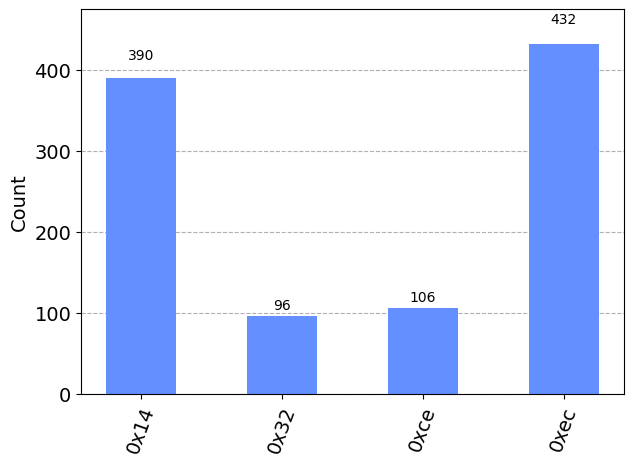

In [441]:
#Solution
def signal(t):
    # Define the signal as the superposition of two sinusoidal functions with different frequencies.
    return np.sin(2*np.pi*20*t) + 0.5*np.sin(2*np.pi*50*t)

# Define number of sampling points
n = 8
N = 2**n

# Sample signal and normalize
input = np.array([signal(i/N) for i in range(N)])
input = input / np.linalg.norm(input)

qc = QuantumCircuit(n)
qc.initialize(Statevector(input)) 
qc.compose(circuit.library.QFT(num_qubits=n), inplace=True)
qc.measure_all()

backend = BasicProvider().get_backend('basic_simulator')
new_circuit = transpile(qc, backend)
job = backend.run(new_circuit)
counts=job.result().results[0].data.counts
plot_histogram(counts)
#the two higher peaks cirrespond to the first function and the two lower peaks to the second function. The peak height which shows the measurement probability is not linear with the function amplitudes but quadratic, because the probability of the state is the square of the absolute value of a state's amplitude.

***

## Exercise 2

Implement Grover's algorithm as shown in the presentation for 4 qubits and the function $f(x)=(7x) mod 15$. We want to solve $f(x)=1$.

Follow the steps:

1. Implement the modulo-circuit for $f(x)=(7x) mod 15$ with Qiskit. Try with $x=3$ if you get the expected result.

2. The operation that marks the state $y=|01\rangle$ as shown in the presentation is

> qc.x(0)

> qc.cz(0,1)

> qc.x(0)

Compute the matrix representation of this operation. Which shape does the matrix have?

3. Implement the marking operation for the state $y=1=|0001\rangle$. This is not easy to do by hand but you can use a workaround by specifying its matrix representation and then have Qiskit transform it into a series of gates.

4. Combine the first four stages of Grover's algorithm: generating a superposition, applying the function f, marking the wanted state,, and applying the inverse of f. Which state vector results from this and what does this mean for the $x$ that solves $f(x)=1$?

5. The final missing part is the Grover diffuser. As it is also not easy to build it by hand for a 4 qubit-system we use its definition:

```
from qiskit.quantum_info import DensityMatrix
diffuse_operator = 2*DensityMatrix.from_label('0000') - Operator.from_label('IIII')
qc.h(0)
qc.h(1)
qc.h(2)
qc.h(3)
qc.unitary(diffuse_operator,qr)
qc.h(0)
qc.h(1)
qc.h(2)
qc.h(3)
```

to build and apply it to the circuit with Qiskit. Sample measurements and deduce the solution for $x$. What is the probablity for measuring the correct solution for $x$?

6. Apply the whole circuit except for the Hadamard gates the create the initial superposition twice. What is the probablity for measuring the correct solution for $x$ now?

In [412]:
#write your code here

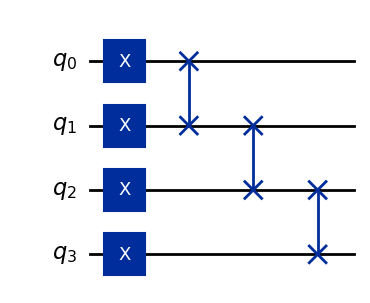

In [3]:
#Solution for task 1
qc = QuantumCircuit(4)
qc.x(0)
qc.x(1)
qc.x(2)
qc.x(3)
qc.swap(0,1)
qc.swap(1,2)
qc.swap(2,3)

qc.draw('mpl')

In [9]:
#example for input=0011=3
qc = QuantumCircuit(4)
qc.x(0)
qc.x(1)

qc.x(0)
qc.x(1)
qc.x(2)
qc.x(3)
qc.swap(0,1)
qc.swap(1,2)
qc.swap(2,3)

print(Statevector(qc))
#this gives 0110=6

Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2))


In [5]:
#Solution for task 2
qc=QuantumCircuit(2)
qc.x(0)
qc.cz(0,1)
qc.x(0)
Operator(qc).data
#the matrix is diagonal with ones on the diagonal except for the third row/column where -1 is on the diagonal.

array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j]])

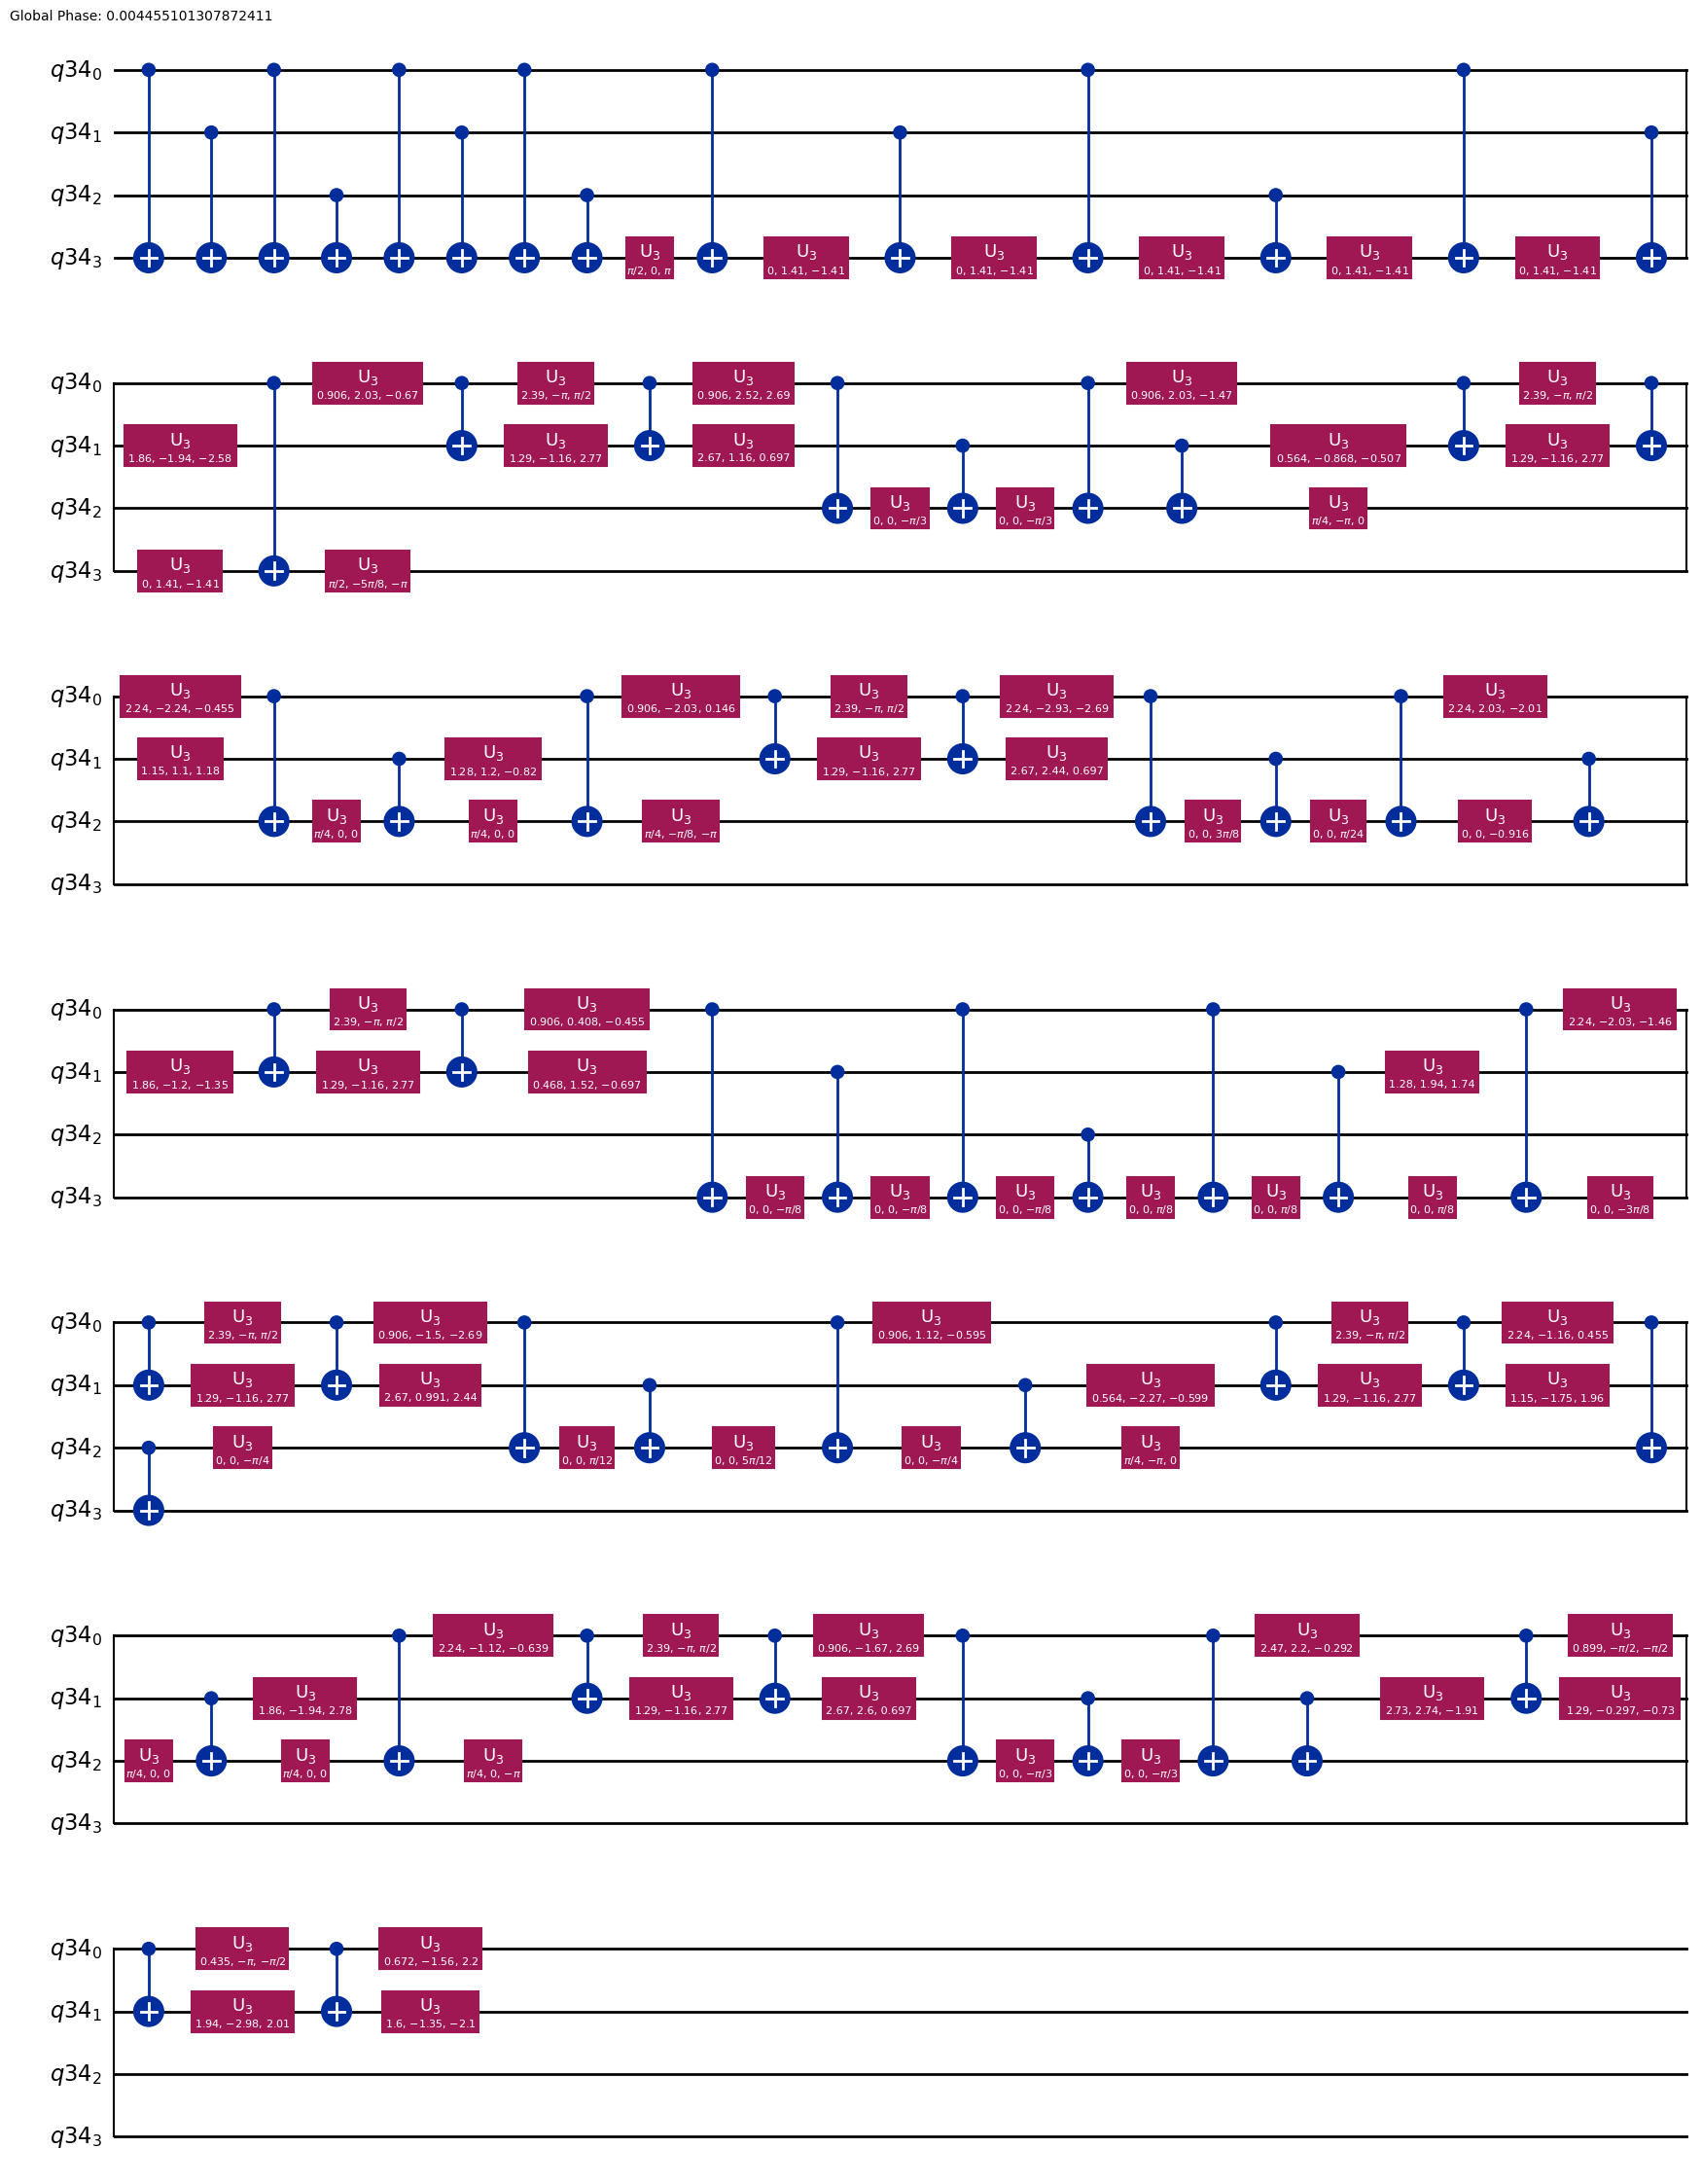

In [10]:
#Solution for task 3
U=np.eye(16,16)
U[1,1]=-1 # y=1

qr=QuantumRegister(4)
circ = QuantumCircuit(qr)
circ.unitary(U,qr)
circ = transpile(circ, basis_gates=['cx','u3'])
circ.draw('mpl')

In [11]:
#Solution for task 4
U=np.eye(16,16)
U[1,1]=-1 #y=1
#an alternative way is
from qiskit.quantum_info import DensityMatrix
U = Operator.from_label('IIII') - 2*DensityMatrix.from_label('1000')

qr=QuantumRegister(4)
qc = QuantumCircuit(qr)
qc.h(0)
qc.h(1)
qc.h(2)
qc.h(3)

qc.x(0)
qc.x(1)
qc.x(2)
qc.x(3)
qc.swap(0,1)
qc.swap(1,2)
qc.swap(2,3)

qc.unitary(U,qr)

qc.swap(2,3)
qc.swap(1,2)
qc.swap(0,1)
qc.x(3)
qc.x(2)
qc.x(1)
qc.x(0)
print(Statevector(qc))
#this corresponds to the state x=13 because
#(x)_reversed=11=1011=(1101)_reversed=(13)_reversed

Statevector([ 0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,
              0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,
              0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j, -0.25+0.j,
              0.25+0.j],
            dims=(2, 2, 2, 2))


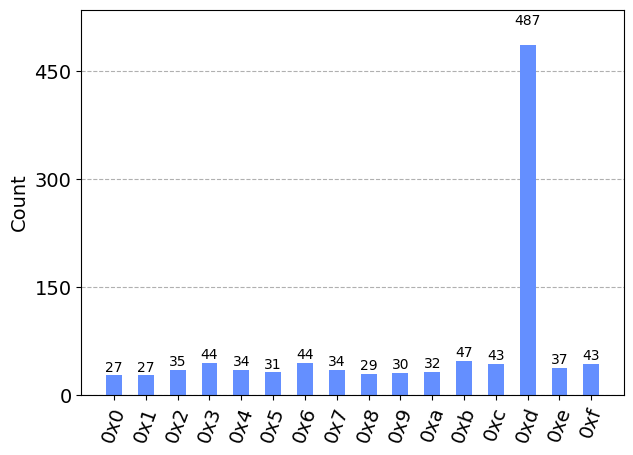

In [14]:
#Solution for task 5
U=np.eye(16,16)
U[1,1]=-1

qr=QuantumRegister(4)
qc = QuantumCircuit(qr)
qc.h(0)
qc.h(1)
qc.h(2)
qc.h(3)

qc.x(0)
qc.x(1)
qc.x(2)
qc.x(3)
qc.swap(0,1)
qc.swap(1,2)
qc.swap(2,3)

qc.unitary(U,qr)

qc.swap(2,3)
qc.swap(1,2)
qc.swap(0,1)
qc.x(3)
qc.x(2)
qc.x(1)
qc.x(0)

from qiskit.quantum_info import DensityMatrix
diffuse_operator = 2*DensityMatrix.from_label('0000') - Operator.from_label('IIII')
qc.h(0)
qc.h(1)
qc.h(2)
qc.h(3)
qc.unitary(diffuse_operator,qr)
qc.h(0)
qc.h(1)
qc.h(2)
qc.h(3)
#print(Statevector(qc))

qc.measure_all()
backend = BasicProvider().get_backend('basic_simulator')
new_circuit = transpile(qc, backend)
job = backend.run(new_circuit)
counts=job.result().results[0].data.counts
plot_histogram(counts)

#The probabilty for measuring 0xd=13=1101 is about 50%. 

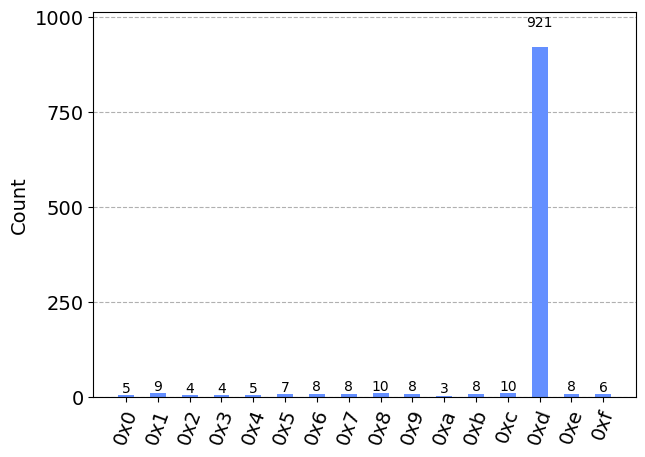

In [15]:
#Solution for task 5
U=np.eye(16,16)
U[1,1]=-1

qr=QuantumRegister(4)
qc = QuantumCircuit(qr)
qc.h(0)
qc.h(1)
qc.h(2)
qc.h(3)

qc.x(0)
qc.x(1)
qc.x(2)
qc.x(3)
qc.swap(0,1)
qc.swap(1,2)
qc.swap(2,3)

qc.unitary(U,qr)

qc.swap(2,3)
qc.swap(1,2)
qc.swap(0,1)
qc.x(3)
qc.x(2)
qc.x(1)
qc.x(0)

from qiskit.quantum_info import DensityMatrix
diffuse_operator = 2*DensityMatrix.from_label('0000') - Operator.from_label('IIII')
qc.h(0)
qc.h(1)
qc.h(2)
qc.h(3)
qc.unitary(diffuse_operator,qr)
qc.h(0)
qc.h(1)
qc.h(2)
qc.h(3)

qc.x(0)
qc.x(1)
qc.x(2)
qc.x(3)
qc.swap(0,1)
qc.swap(1,2)
qc.swap(2,3)

qc.unitary(U,qr)

qc.swap(2,3)
qc.swap(1,2)
qc.swap(0,1)
qc.x(3)
qc.x(2)
qc.x(1)
qc.x(0)

from qiskit.quantum_info import DensityMatrix
diffuse_operator = 2*DensityMatrix.from_label('0000') - Operator.from_label('IIII')
qc.h(0)
qc.h(1)
qc.h(2)
qc.h(3)
qc.unitary(diffuse_operator,qr)
qc.h(0)
qc.h(1)
qc.h(2)
qc.h(3)
#print(Statevector(qc))

qc.measure_all()
backend = BasicProvider().get_backend('basic_simulator')
new_circuit = transpile(qc, backend)
job = backend.run(new_circuit)
counts=job.result().results[0].data.counts
plot_histogram(counts)

#The probabilty for measuring 0xd=13=1101 is now more than 90%. 

***

## Exercise 3

The circuit in the file `qft.qasm` is the quantum Fourier transform (QFT) for 4 qubits and operates for $n$ qubits as

$$|j\rangle \mapsto \frac{1}{2^{n/2}} \sum_{k=0}^{2^n-1} e^{2\pi i jk/2^n}|k\rangle$$

1. Read it in with

> qft=QuantumCircuit.from_qasm_file("qft.qasm")

and find out the meaning of the gate types you don't know yet from the Qiskit documentation. (e.g. https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit)

2. Get the matrix representation of the circuit.
3. Build circuit for the inverse quantum Fourier transform with:

> qft.inverse()

then plot it and compare its matrix representation to the matrix representation of the quantum Fourier transform. How are the two matrices related to each other? (Hint: try to multiply them with each other.)

4. Read in the circuit from the file `middle.qasm`.

4. Set up a quantum program with 8 qubits and 4 measurement bits and the structure

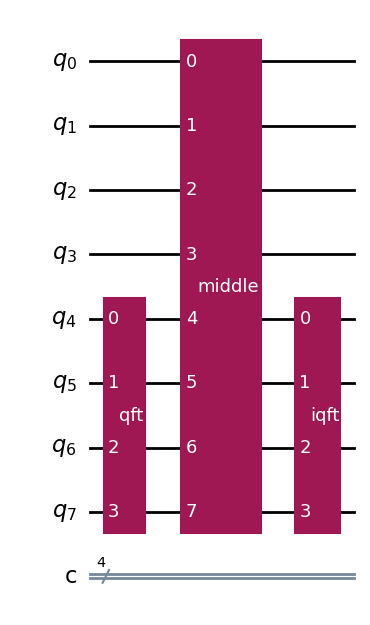

In [313]:
qc = QuantumCircuit(8,4)
qc=qc.compose(circuit.Gate("qft",4,[]),[4,5,6,7])

qc=qc.compose(circuit.Gate("middle",8,[]),[0,1,2,3,4,5,6,7])

qc=qc.compose(circuit.Gate("iqft",4,[]),[4,5,6,7])
qc.draw('mpl')

Insert the circuit for the QFT, it's inverse, and middle into the above circuit.
 
You can append an existing circuit to another circuit with

> QuantumCircuit.compose(other, qubits=None)

That means to append the qft-circuit to the qc-circuit on the last 4 qubits you can use

> qc=qc.compose(qft,[4,5,6,7])

Add measurements for the last 4 qubits. Find out from the documentation (https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#measure) how to measure just a subset of qubits instead of all. Simulate the resulting circuit with the basic_simulator-backend and plot the histogram.

5. Use the circuit to try to find out what the circuit is actually doing. For this purpose, make a table of inputs and list the resulting measurement.

Hint: An input means that we first create a state with flip-gates like

> qc.x(0)

> qc.x(4)

and then apply the circuit.

Hint: The circuit can be found in https://arxiv.org/abs/2005.00443.

In [155]:
#Please write your Python code here

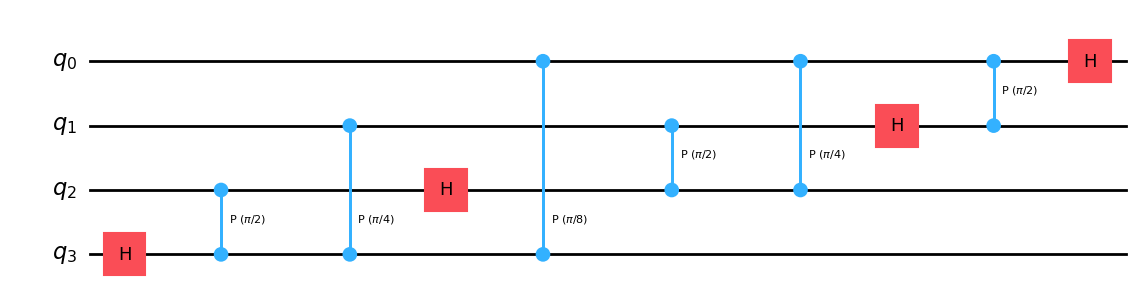

In [260]:
#Solution for task 1
qft=QuantumCircuit.from_qasm_file("qft.qasm")
qft.draw(output='mpl')
# cp is the controlled phase-gate: https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#cp

In [261]:
#Solution for task 2
Operator(qft)

Operator([[ 2.50000000e-01+0.j        ,  2.50000000e-01+0.j        ,
            2.50000000e-01+0.j        ,  2.50000000e-01+0.j        ,
            2.50000000e-01+0.j        ,  2.50000000e-01+0.j        ,
            2.50000000e-01+0.j        ,  2.50000000e-01+0.j        ,
            2.50000000e-01+0.j        ,  2.50000000e-01+0.j        ,
            2.50000000e-01+0.j        ,  2.50000000e-01+0.j        ,
            2.50000000e-01+0.j        ,  2.50000000e-01+0.j        ,
            2.50000000e-01+0.j        ,  2.50000000e-01+0.j        ],
          [ 2.50000000e-01+0.j        , -2.50000000e-01+0.j        ,
            2.50000000e-01+0.j        , -2.50000000e-01+0.j        ,
            2.50000000e-01+0.j        , -2.50000000e-01+0.j        ,
            2.50000000e-01+0.j        , -2.50000000e-01+0.j        ,
            2.50000000e-01+0.j        , -2.50000000e-01+0.j        ,
            2.50000000e-01+0.j        , -2.50000000e-01+0.j        ,
            2.50000000e-01+0.j   

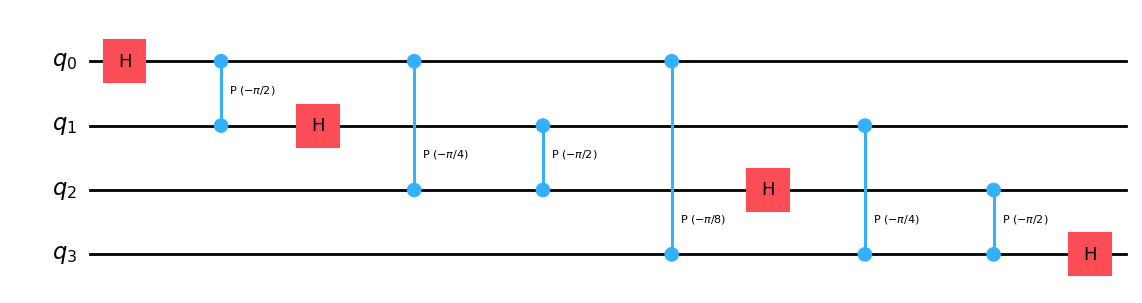

In [262]:
#Solution for task 3
iqft=qft.inverse()
iqft.draw(output='mpl')

In [263]:
Operator(iqft)

Operator([[ 2.50000000e-01+0.j        ,  2.50000000e-01+0.j        ,
            2.50000000e-01+0.j        ,  2.50000000e-01+0.j        ,
            2.50000000e-01+0.j        ,  2.50000000e-01+0.j        ,
            2.50000000e-01+0.j        ,  2.50000000e-01+0.j        ,
            2.50000000e-01+0.j        ,  2.50000000e-01+0.j        ,
            2.50000000e-01+0.j        ,  2.50000000e-01+0.j        ,
            2.50000000e-01+0.j        ,  2.50000000e-01+0.j        ,
            2.50000000e-01+0.j        ,  2.50000000e-01+0.j        ],
          [ 2.50000000e-01+0.j        , -2.50000000e-01+0.j        ,
            1.53080850e-17-0.25j      , -1.53080850e-17+0.25j      ,
            1.76776695e-01-0.1767767j , -1.76776695e-01+0.1767767j ,
           -1.76776695e-01-0.1767767j ,  1.76776695e-01+0.1767767j ,
            2.30969883e-01-0.09567086j, -2.30969883e-01+0.09567086j,
           -9.56708581e-02-0.23096988j,  9.56708581e-02+0.23096988j,
            9.56708581e-02-0.2309

In [264]:
np.matmul(Operator(iqft),Operator(qft))
# the product of the matrix representation of a circuit and the matrix representation of the inverse of the circuit is a unit matrix.

array([[ 1.00000000e+00+0.00000000e+00j, -5.35431836e-18-2.44214165e-18j,
        -8.41828992e-19+8.41828992e-19j,  2.44214165e-18-1.58457554e-18j,
         1.38777878e-17+1.38777878e-17j, -2.44214165e-18-1.58457554e-18j,
         8.41828992e-19+8.41828992e-19j,  5.35431836e-18-2.44214165e-18j,
         1.38777878e-17+0.00000000e+00j,  5.35431836e-18+2.44214165e-18j,
         8.41828992e-19-8.41828992e-19j, -2.44214165e-18+1.58457554e-18j,
         1.38777878e-17-1.38777878e-17j,  2.44214165e-18+1.58457554e-18j,
        -8.41828992e-19-8.41828992e-19j, -5.35431836e-18+2.44214165e-18j],
       [-5.35431836e-18+2.44214165e-18j,  1.00000000e+00-4.34846642e-17j,
         7.86095065e-18+5.20555091e-18j, -2.34820297e-17+9.93800424e-18j,
        -4.49675226e-18-3.04911317e-18j,  6.40681913e-17-6.63597736e-19j,
        -7.85818968e-18-1.13303976e-17j,  1.38144748e-17-5.08759312e-18j,
         5.35431836e-18-2.44214165e-18j,  1.39441980e-16+2.61374295e-17j,
         6.01683716e-18-5.20555091e-1

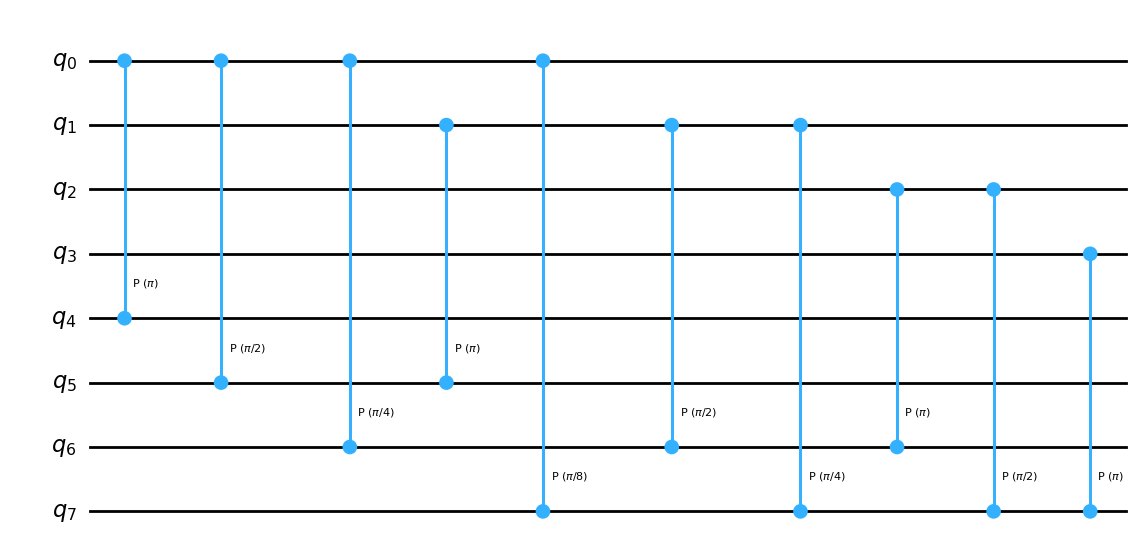

In [265]:
middle=QuantumCircuit.from_qasm_file("middle.qasm")
middle.draw('mpl')

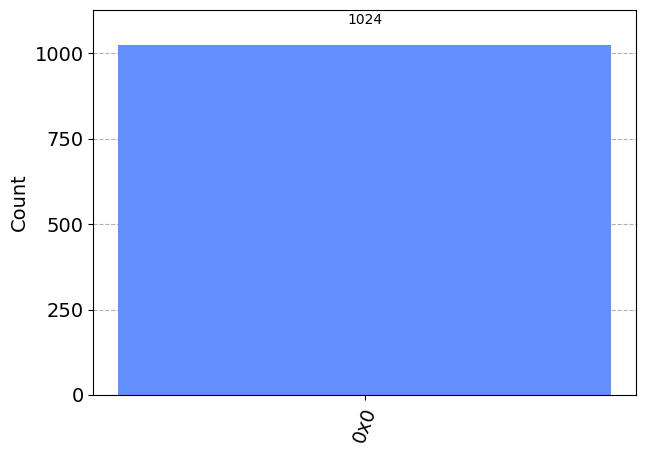

In [266]:
#Solution for Task 4
qc = QuantumCircuit(8,4)
qft=QuantumCircuit.from_qasm_file("qft.qasm")
iqft=qft.inverse()

qc=qc.compose(qft,[4,5,6,7])
middle=QuantumCircuit.from_qasm_file("middle.qasm")
qc=qc.compose(middle,[0,1,2,3,4,5,6,7])

qc=qc.compose(iqft,[4,5,6,7])
qc.measure([4,5,6,7],[0,1,2,3])

backend = BasicProvider().get_backend('basic_simulator')
new_circuit = transpile(qc, backend)
job = backend.run(new_circuit)
counts=job.result().results[0].data.counts
plot_histogram(counts)

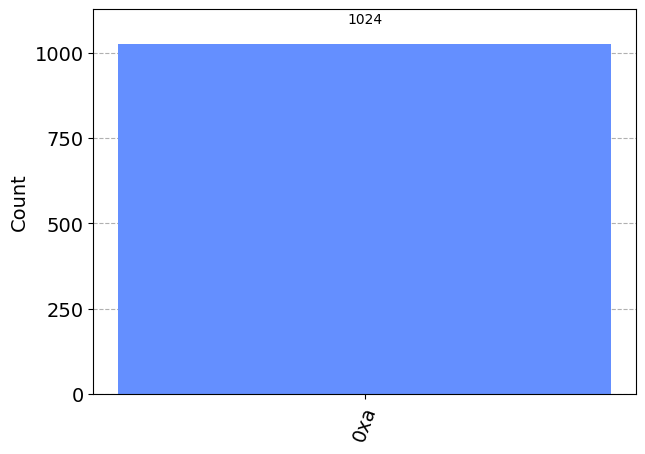

In [295]:
#Solution for Task 5
qc = QuantumCircuit(8,4)
qft=QuantumCircuit.from_qasm_file("qft.qasm")
iqft=qft.inverse()
#add 7 and 3
qc.x(0)
qc.x(1)
qc.x(2)

qc.x(4)
qc.x(5)

#gives 0xa=10

qc=qc.compose(qft,[4,5,6,7])
middle=QuantumCircuit.from_qasm_file("middle.qasm")
qc=qc.compose(middle,[0,1,2,3,4,5,6,7])

qc=qc.compose(iqft,[4,5,6,7])
qc.measure([4,5,6,7],[0,1,2,3])

backend = BasicProvider().get_backend('basic_simulator')
new_circuit = transpile(qc, backend)
job = backend.run(new_circuit)
counts=job.result().results[0].data.counts
plot_histogram(counts)

# This circuit adds the number represented by the first four qubits and the number represented by the last 4 qubits modulo 16.


***

## Exercise 4

Let us now consider the first quantum algorithm that demonstrated an exponential speedup compared to the best classical algorithm, namely Simon’s algorithm.

Suppose $f \colon \{0, 1\}^n \to \{0, 1\}^n$ is a function that is either one-to-one (maps exactly one input to every unique output) or two-to-one (maps exactly two inputs to every unique output) such that

$f(x) = f(y) \Leftrightarrow x = y \oplus b$


for all $x, y \in \{0, 1\}^n$, where $\oplus$ denotes bitwise XOR (returns a 1 in each bit position where the corresponding bits of either - but not both - operands are 1s, and returns a 0 in all other cases).

Find the hidden bitstring $b \in \{0, 1\}^n$ by making as few queries to $f(x)$ as possible!

1. The quantum circuit of Simon's algorithm consists of two quantum registers with $n$ qubits. This time, we also need a classical register in Qiskit to store the measurement outcomes from our circuit. Use

> q_reg1 = QuantumRegister (n)
>
> q_reg2 = QuantumRegister (n)
>
> c_reg = ClassicalRegister (n)
>
> qc = QuantumCircuit (q_reg1, q_reg2, c_reg)

with $n=4$. Then apply Hadamard gates on all qubits in the first register and apply the following oracle $U_f$ which corresponds to a (unknown) two-to-one function as described above:

> qc.cx(q_reg1, q_reg2)
> 
> qc.cx(q_reg1[0],q_reg2[0])
> 
> qc.cx(q_reg1[0],q_reg2[2])

If $U_f | x, 0^n \rangle = | x, f(x) \rangle $ for all $x \in \{0, 1\}^n$, what is the quantum state at this point?

2. Now, we measure the second quantum register. This can be done by using

> qc.measure(q_reg2, c_reg)

The measuring process makes the quantum state of the first register collapse into a superposition. Suppose we measure $f(x)$, what is then the quantum state in the first register?

3. To complete Simon's algorithm, we again have to apply Hadamard gates on all qubits in the first register and then measure the first register. Draw the circuit, simulate it, and plot the histogram.

4. The important fact is now, that any bitstring $z$ that we measure satisfies $z \cdot b = 0~(\text{mod }2)$, where $\cdot$ denotes the bitwise inner product, i.e., $z \cdot b = z_0 b_0 + z_1 b_1 + \ldots~(\text{mod }2)$. Deduce the hidden bitstring $b \neq 0$ from your measurements.

In [ ]:
# put your code here

In [301]:
#Solution for task 1
n=4
q_reg1 = QuantumRegister (n)
q_reg2 = QuantumRegister (n)
c_reg = ClassicalRegister (n)
qc = QuantumCircuit (q_reg1, q_reg2, c_reg)
qc.h(q_reg1[0])
qc.h(q_reg1[1])
qc.h(q_reg1[2])
qc.h(q_reg1[3])

qc.cx(q_reg1, q_reg2)
qc.cx(q_reg1[0],q_reg2[0])
qc.cx(q_reg1[0],q_reg2[2])

print(Statevector(qc))


Statevector([0.25+0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.25+0.j,
             0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
             0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
             0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
             0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
             0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.25+0.j, 0.  +0.j,
             0.  +0.j, 0.  +0.j, 0.  +0.j, 0.25+0.j, 0.  +0.j, 0.  +0.j,
             0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
             0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
             0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
             0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.25+0.j,
             0.  +0.j, 0.  +0.j, 0.25+0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
             0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
             0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j

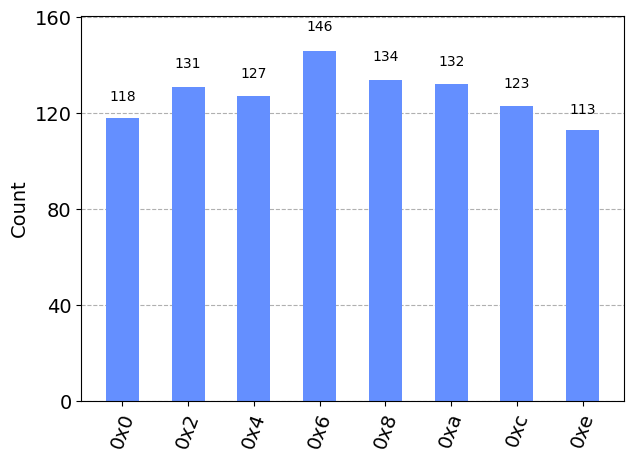

In [442]:
#Solution for task 2
n=4
q_reg1 = QuantumRegister (n)
q_reg2 = QuantumRegister (n)
c_reg = ClassicalRegister (n)
qc = QuantumCircuit (q_reg1, q_reg2, c_reg)
qc.h(q_reg1[0])
qc.h(q_reg1[1])
qc.h(q_reg1[2])
qc.h(q_reg1[3])

qc.cx(q_reg1, q_reg2)
qc.cx(q_reg1[0],q_reg2[0])
qc.cx(q_reg1[0],q_reg2[2])

qc.measure(q_reg2, c_reg)
backend = BasicProvider().get_backend('basic_simulator')
new_circuit = transpile(qc, backend)
job = backend.run(new_circuit)
counts=job.result().results[0].data.counts
plot_histogram(counts)

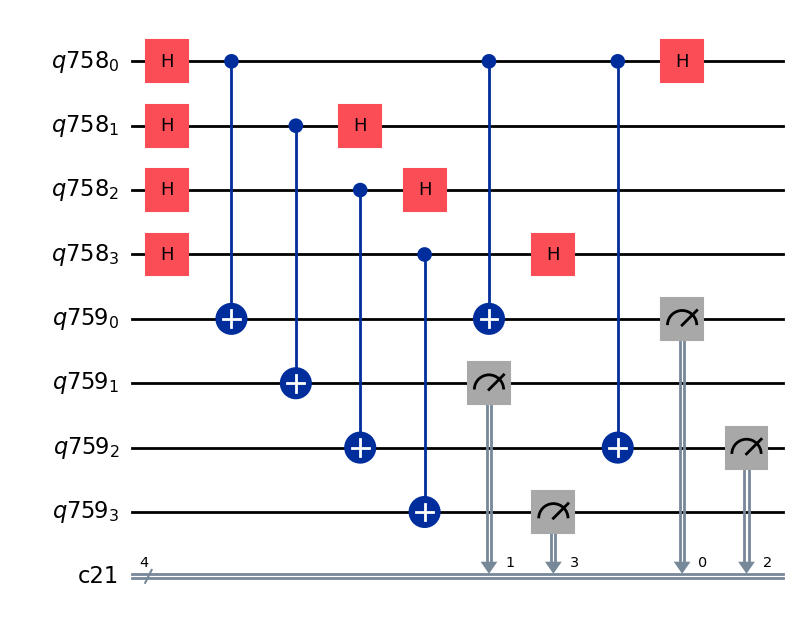

In [308]:
#Solution for task 3
n=4
q_reg1 = QuantumRegister (n)
q_reg2 = QuantumRegister (n)
c_reg = ClassicalRegister (n)
qc = QuantumCircuit (q_reg1, q_reg2, c_reg)
qc.h(q_reg1[0])
qc.h(q_reg1[1])
qc.h(q_reg1[2])
qc.h(q_reg1[3])

qc.cx(q_reg1, q_reg2)
qc.cx(q_reg1[0],q_reg2[0])
qc.cx(q_reg1[0],q_reg2[2])

qc.h(q_reg1[0])
qc.h(q_reg1[1])
qc.h(q_reg1[2])
qc.h(q_reg1[3])
qc.measure(q_reg2, c_reg)
qc.draw('mpl')


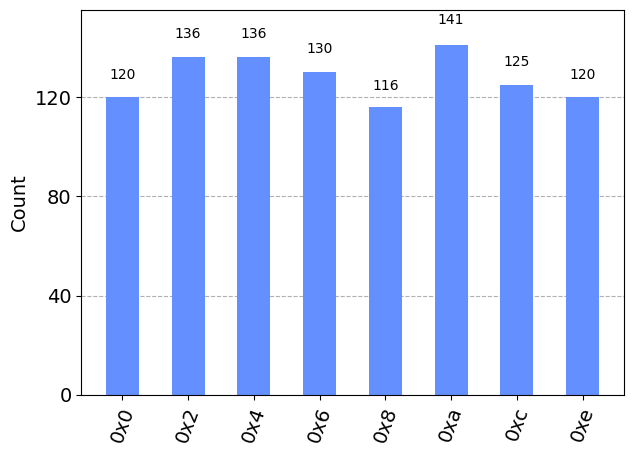

In [309]:
backend = BasicProvider().get_backend('basic_simulator')
new_circuit = transpile(qc, backend)
job = backend.run(new_circuit)
counts=job.result().results[0].data.counts
plot_histogram(counts)

Solution for task 4

The bitstring is 1110.